In [1]:
from functions_trained_reservoir import *

from IPython.display import clear_output

from reservoirpy.nodes import Reservoir,FORCE,Ridge
from reservoirpy.mat_gen import Initializer,_scale_spectral_radius
from reservoirpy.observables import spectral_radius
from tqdm import tqdm

from ReccurentNetwork import *

import numpy as np
import copy
from numpy.linalg import eig

import spicy as sp
import matplotlib.pyplot as plt

In [2]:
#Code importé de ReservoirPy
def _rls(P, x, e):
    """Recursive Least Squares learning rule."""
    k = np.dot(P, x)
    xPx = np.dot(x.T, k)
    c = float(1.0 / (1.0 + xPx))
    P = P - c * np.outer(k, k)
    dw = -c * np.outer(e, k)

    return dw, P

# Réseaux de neurones

On cherche ici dans un premier temps à reprdoduire les figures les plus simples de l'article. 

Les mesures de l'article sont effectuées sur 2 réservoirs : 

  - le premier est dit entrainé : on va alors entrainer le réservoir et la sortie
  - le second lui est dit non entrainé : on entraine seulement la sortie
    

Ce premier script s'intéresse donc à la reproduction de l'entrainement des figures 3, 4 et 5 ainsi qu'aux résultas obtenus sur un réservoir entrainé.


## Expériences

Deux expériences quasiment similaires sont proposés pour un réservoir totalement entrainé. La seule différence entre ces dernières sont le nombre de neurones utilisés dans le réservoir : 

   - Soit N = 2100 pour des résultats robustes entre toutes les données pour un sujet
   - Soit N = 4000 pour des résultats robustes entre tous les sujets (5 au maximum)
    
Nous traiterons le premier  cas dans ce papier.

##### Méthode d'entrainement

Pour ce qui est de l'entrainement du réservoir nous allons procéder comme ceci : nous séparons notre entrée en deux parties : l'époque sensorielle et l'époque motricielle. 

###### Epoque sensorielle : 

Pour un sujet donné et parmit toutes les entrées différentes, pour chaque chiffre on selectionne une entrée moyenne. Cette entrée est injectée dans le réservoir sans bruit et sans target, on obtient alors une trajectoire resultante de taille (Timesteps x Nombre de neurones) pour chaque chiffre. Ces 10 trajectoires sont appelées les "innate trajectories" et seront les targets pour toutes les autres entrées durant l'entrainement du l'époque sensorielle en faisant bien attention à  ce que la dimension d'entrée des nouvelles entrées soit cohérente avec celle de l'innate trajectorie, on procédera alors pas une déformation linéaire de l'innate trajectory. De plus, du bruit sera présent durant l'entrainement.

###### Epoque motrice

Pour ceux qui est de l'époque motrice :

##### Entrainement

On concatene maintenant l'innate trajectory de l'époque sensorielle et de l'époque motrice pour obtenir nos targets finales.

À noter, que chaque entrainement et test commence à -100ms avec le réseau initialisé selon une loi uniform de -1 à 1.
--> On laisse tourner le réservoir pendant 100ms à blanc ouis on met les entrées ????


###### Test
Les test effectués dans ce script seront fait sur le sujet 1

Données générales 

In [3]:
data = extract_data() #Données d'entrée
transcription = extract_target() #Données d'arrivée 

#Les données suivantes sont utilisés dans les fonctions mais pas dans le script ! 

freq_ent = 6*10**3  #fréquence d'entrée
T_ent = 1/freq_ent  #période d'entrée

freq_out = 10**3 #fréquence de sortie 
T_out = 1/freq_out #période de sortie

ampl_int = 5 #Amplitude d'entrée

Données du réservoir

In [4]:
N = 2100//5 #Nombre de neurones dans le réservoir
M = 12 #Nombres d'entrées
No = 3 #Nombres de sorties
tau = 25*10e-3
dt = 1e-3
lr = dt/tau
sr = 1.6 #spectral radius --> gain ?
g = 1.6 #le gain du réseau ?                             #je comprends pas trop cette donnée. 
pc = 0.2 # connectivité entre les neurones (pc dans l'article)
SD = g/np.sqrt(pc*N)
mu = 0
I0 = 0.5 

Wo = normal(No,N,loc=mu,scale = 1/np.sqrt(N))    #Matrice de sortie : Non utilisée


Création de la matrice du réservoir : avec pas d'autapse
Puis bricolage pour réxupérer le rayon spectral voulu

In [5]:
W_r.init = Initializer(W_r)

W = _scale_spectral_radius(W_r.init, [N,N], sr)
W = W.toarray()

Création de la matrice d'entrée : chaque entrée k est projetée sur le neurone $(k-1)\frac{N}{M} + 1$ jusqu'au neurone $k\frac{N}{M}$ selon une loi normale 

In [6]:
Win = W_in(N,M)

# Epoque sensorielle 

Récupération des cocleograms avec une taille moyenne pour chaque chiffre 

In [7]:
median_entrance_cocleogram = median_cocleogram(data,sujet=[1])

Création d'un réservoir :

In [8]:
reservoir_train = Reservoir(W=W,Win=Win)

Détermination des trajectoires inées  

In [9]:
innate_trajectories_sensor = []
innate_trajectories_motor = []
for i in range(len(median_entrance_cocleogram)):
    
    #Récupération du cocleogram moyen
    X =  median_entrance_cocleogram[i]
    
    #Récupération des trajectoires innées de l'époque sensorielle 
    initial_trajectory = reservoir_train.run(X)
    
    #Ensuite on les trie
    innate_trajectories_sensor.append(initial_trajectory)

clear_output()

# Epoque Motrice

# Entrainement 

Pour le blanc de 100 ms, utiliser la méthode with_state.

In [10]:
X_input = []
X_target = []
for indS in [1] : 
    for indU in range(1,4):
        for indD in range(10):
            X_input.append(np.transpose(cocleogram(indS, indU, indD,data)))
            X_target.append(linear_warping(indS,indU,indD,data,innate_trajectories_sensor[indD]))

## Test de RLS sans utiliser le noeud de reservoirpy

On laisse d'abord tourner le réservoir pendant 100ms (avec une période de 1ms), et on récupère l'état des neurones pour l'injecter dans un réservoir et commencer notre entrainement.

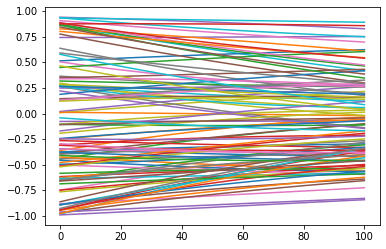

In [36]:
x= np.random.uniform(-1,1,(N,1))
etat = x.T
I_noise = np.random.normal(0,1,size =np.shape(x)) + SD*I0
W_rls = copy.deepcopy(W)

for i in range(100):
    x_1 = (1-lr)*x + lr*np.tanh(np.dot(W_rls,x)) #+ I_noise/1000 le rajout de bruit fait diverger le système
    etat = np.append(etat,x_1.T,axis = 0)
    x = x_1

x_final = x_1

plt.plot(etat[:,:100])
clear_output()


In [37]:
P = np.identity(N)                                                  # matrice de gain ?
W_rls = copy.deepcopy(W)
c = 0

x = x_final

for xi,xt in tqdm(zip(X_input,X_target)):                              #entrainement
    error = []
    for t in range(len(xi)):                                           # pour 1 pas de temps 
        
        I_noise = np.random.normal(0,1,size =np.shape(x)) + SD*I0                     #bruit dans le réservoir
        
        x1 = (1-lr)*x + lr*np.tanh(np.dot(Win,np.expand_dims(xi[t], axis=1))+np.dot(W_rls,x))  #calcul de x(t+1)
        
        e = np.expand_dims(xt[t],axis=1) - x1                       #calcul de l'erreur pour un seul pas de temps
        
        
        dW_rls,P = _rls(P, x1, e)                                       #calcul du rls pour un pas de temps 
        
        W_rls -= dW_rls
        
        x = x1
        
        error.append(e)
    
    c += 1
        
    print("moyenne des erreurs sur l'entrainement {} : {} ".format(c,moyenne(e)))
        


1it [00:02,  2.01s/it]

moyenne des erreurs sur l'entrainement 1 : [0.01024726] 


2it [00:03,  1.82s/it]

moyenne des erreurs sur l'entrainement 2 : [0.02732917] 


3it [00:05,  1.88s/it]

moyenne des erreurs sur l'entrainement 3 : [0.001033] 


4it [00:08,  2.08s/it]

moyenne des erreurs sur l'entrainement 4 : [-0.00404314] 


5it [00:10,  2.15s/it]

moyenne des erreurs sur l'entrainement 5 : [0.04538843] 


6it [00:12,  2.31s/it]

moyenne des erreurs sur l'entrainement 6 : [0.00651195] 


7it [00:15,  2.52s/it]

moyenne des erreurs sur l'entrainement 7 : [0.02668841] 


8it [00:18,  2.51s/it]

moyenne des erreurs sur l'entrainement 8 : [-0.02382542] 


9it [00:20,  2.35s/it]

moyenne des erreurs sur l'entrainement 9 : [0.00129331] 


10it [00:22,  2.40s/it]

moyenne des erreurs sur l'entrainement 10 : [0.00697966] 


11it [00:24,  2.27s/it]

moyenne des erreurs sur l'entrainement 11 : [-0.01001606] 


12it [00:26,  2.06s/it]

moyenne des erreurs sur l'entrainement 12 : [0.043408] 


13it [00:28,  1.99s/it]

moyenne des erreurs sur l'entrainement 13 : [0.0188627] 


14it [00:30,  2.01s/it]

moyenne des erreurs sur l'entrainement 14 : [-0.0147171] 


15it [00:32,  2.11s/it]

moyenne des erreurs sur l'entrainement 15 : [0.02462486] 


16it [00:35,  2.34s/it]

moyenne des erreurs sur l'entrainement 16 : [0.01076519] 


17it [00:38,  2.53s/it]

moyenne des erreurs sur l'entrainement 17 : [0.00994781] 


18it [00:41,  2.63s/it]

moyenne des erreurs sur l'entrainement 18 : [-0.01758255] 


19it [00:43,  2.47s/it]

moyenne des erreurs sur l'entrainement 19 : [-0.00124855] 


20it [00:46,  2.54s/it]

moyenne des erreurs sur l'entrainement 20 : [0.02665857] 


21it [00:48,  2.41s/it]

moyenne des erreurs sur l'entrainement 21 : [-0.01433316] 


22it [00:49,  2.19s/it]

moyenne des erreurs sur l'entrainement 22 : [0.01730036] 


23it [00:51,  2.13s/it]

moyenne des erreurs sur l'entrainement 23 : [-0.02053846] 


24it [00:54,  2.25s/it]

moyenne des erreurs sur l'entrainement 24 : [-0.01120077] 


25it [00:56,  2.29s/it]

moyenne des erreurs sur l'entrainement 25 : [0.03404839] 


26it [00:59,  2.41s/it]

moyenne des erreurs sur l'entrainement 26 : [-0.00190877] 


27it [01:02,  2.64s/it]

moyenne des erreurs sur l'entrainement 27 : [0.02241578] 


28it [01:06,  2.87s/it]

moyenne des erreurs sur l'entrainement 28 : [-0.00430384] 


29it [01:08,  2.82s/it]

moyenne des erreurs sur l'entrainement 29 : [0.02635157] 


30it [01:11,  2.39s/it]

moyenne des erreurs sur l'entrainement 30 : [0.02564961] 


Affichage des valeurs propres

C:\Users\smoot\Desktop\Stage Mnemosyne\functions_trained_reservoir.py:465: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


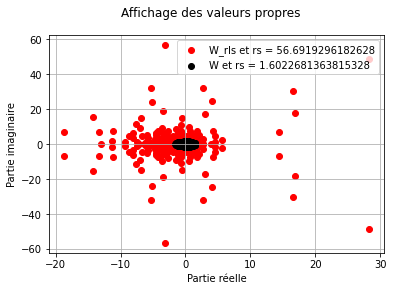

In [38]:
eigein_value(W_rls,W,"W_rls","W")

Test :

In [39]:
X_test = X_input[1]
X_target_test = X_target[1]
x = np.random.normal(0,1,(N,1))

X_pred = []

for t in tqdm(range(len(X_test))):
    x1 = (1-lr)*x + lr*np.tanh(np.dot(Win,np.expand_dims(X_test[t], axis=1))+np.dot(W,x))
    
    if len(X_pred) == 0:
        X_pred = np.transpose(x1)
    else : 
        X_pred = np.append(X_pred,np.transpose(x1),axis = 0)
    
    x = x1

100%|██████████████████████████████████████████████████████████████████████████████| 448/448 [00:00<00:00, 2877.48it/s]


Affichage des résultats (pas représentatif)

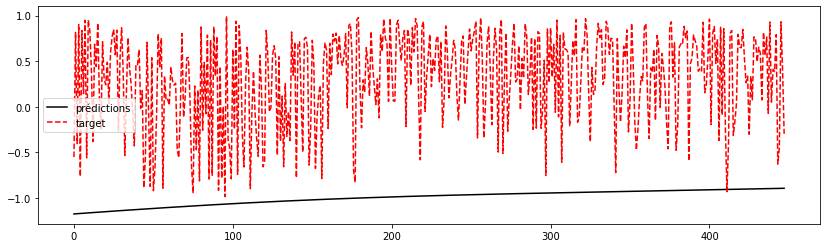

In [40]:
fig,ax = plt.subplots(figsize = (14,4))
ax.plot(X_pred[:,:1],"k",label="prédictions")
ax.plot(X_target_test[:,:1],"--r",label = 'target')
ax.legend()

## Test de RLS en utilisant le noeud de reservoirpy

Entrainement

In [41]:
W_reservoir = copy.deepcopy(W)
reservoir = Reservoir(W=W_reservoir,Win=Win,rc_noise = SD*I0)
P = np.identity(N)

np.shape(xt)

for xi,xt in tqdm(zip(X_input,X_target)):
    x1 = reservoir.run(xi)
    e = x1-xt
    for t in range(len(x1)):
        dW, P = _rls(P,x1[t],e[t])
        W_reservoir -= dW
    reservoir.set_param("W",W_reservoir)

    clear_output()
    #print(moyenne(e))
    

30it [01:09,  2.32s/it]


Affichage des valeurs propores :

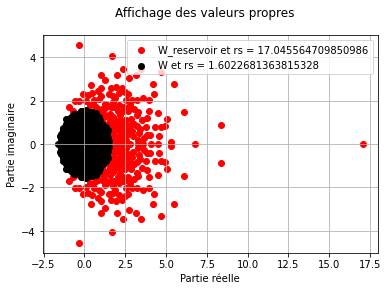

In [42]:
eigein_value(W_reservoir,W,"W_reservoir","W")

Test du réservoir 

In [43]:
X_test = X_input[1]
X_target_test = X_target[1]

X_pred = reservoir.run(X_test)

Running Reservoir-1: 100%|█████████████████████████████████████████████████████████| 448/448 [00:00<00:00, 4977.90it/s]


Affichage des résultats (pas représentatif)

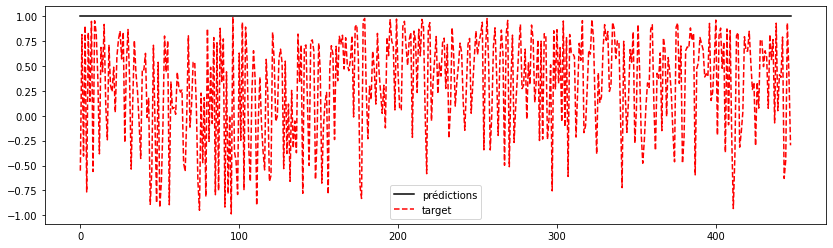

In [44]:
fig,ax = plt.subplots(figsize = (14,4))
ax.plot(X_pred[:,:1],"k",label="prédictions")
ax.plot(X_target_test[:,:1],"--r",label = 'target')
ax.legend()